### **Feature Engineering, Model Design, and Evaluation for Fake News Detection**

This section focuses on preprocessing diverse datasets, engineering meaningful features, and designing robust machine learning models for fake news detection.

**Key Objectives:**

1. Preprocessing and handling individual datasets (Buzzfeed, FNC, LIAR, Politifact) while addressing unique structures and class imbalances.

2. Extracting features using TF-IDF, dimensionality reduction, and sentiment analysis to capture the nuances of fake and real news.

3. Training and evaluating models (Logistic Regression, Random Forest, XGBoost) tailored for dataset-specific and unified analyses.

4. Assessing model performance using diverse metrics (accuracy, precision, recall, F1-score) to identify the most effective approaches.

5. Comparing individual and merged datasets for a holistic evaluation.

This integrated pipeline ensures the transformation of raw data into actionable insights, enabling the development of accurate and scalable fake news detection systems.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
''' Feature Engineering and Model Evaluation Pipeline for Fake News Detection
 Processing individual datasets (Buzzfeed, FNC, LIAR, Politifact), extracts features, handles class imbalance,
 and trains models (Logistic Regression, Random Forest, XGBoost) for performance evaluation. '''


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, RandomOverSampler

# Dataset paths
datasets = {
    "Buzzfeed": "/content/Buzzfeed.csv",
    "FNC": "/content/FNC.csv",
    "LIAR": "/content/LIAR.csv",
    "Politifact": "/content/Politifact.csv"
}

def display_results(name, results):
    """Display classification results in percentages."""
    print(f"\n=== Results for {name} ===")
    for model_name, metrics in results.items():
        print(f"\n{model_name} Classification Report:")
        for label, metric in metrics.get('labels', {}).items():
            print(f"Label {label}: Precision: {metric['precision']*100:.2f}%, Recall: {metric['recall']*100:.2f}%, F1-Score: {metric['f1-score']*100:.2f}%")
        print(f"{model_name} Overall Accuracy: {metrics['accuracy']*100:.2f}%")

def preprocess_dataset(df, name):
    """Preprocess dataset by mapping labels and combining text columns."""
    if 'label' not in df.columns or ('title' not in df.columns and 'text' not in df.columns):
        raise ValueError(f"Dataset {name} is missing required columns.")

    # Convert labels to uppercase and map to binary
    df['label'] = df['label'].astype(str).str.strip().str.upper()
    label_mapping = {"TRUE": 1, "FALSE": 0}
    df = df[df['label'].isin(label_mapping.keys())]
    df['label'] = df['label'].map(label_mapping).astype(int)
    if df.empty:
        raise ValueError(f"Dataset {name} has no valid data after label mapping.")

    # Combine title and text columns
    df['title'] = df['title'].fillna("No Title")
    df['text'] = df.get('text', pd.Series([""] * len(df))).fillna("No Text")
    df['combined_text'] = df['title'] + " " + df['text']

    # Drop rows with invalid or missing text data
    df = df[df['combined_text'].notnull() & df['combined_text'].str.strip().astype(bool)]
    return df

def process_dataset(name, path):
    """Process a single dataset for preprocessing and modeling."""
    try:
        print(f"\nProcessing Dataset: {name}")
        df = pd.read_csv(path)
        df = preprocess_dataset(df, name)
        print(f"Shape After Preprocessing: {df.shape}")

        # TF-IDF vectorization
        print("Applying TF-IDF...")
        tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

        # Dimensionality reduction
        print("Reducing Dimensionality...")
        svd = TruncatedSVD(n_components=500, random_state=42)
        reduced_features = svd.fit_transform(tfidf_matrix)

        # Combine features
        labels = df['label'].values

        # Train-test split
        print(f"Splitting Data for {name}...")
        X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, stratify=labels, random_state=42)

        # Handle class imbalance
        try:
            print(f"Applying ADASYN for {name}...")
            adasyn = ADASYN(random_state=42)
            X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
        except Exception as e:
            print(f"Error applying ADASYN: {e}")
            print("Falling back to RandomOverSampler...")
            ros = RandomOverSampler(random_state=42)
            X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_balanced)
        X_test_scaled = scaler.transform(X_test)

        # Initialize results dictionary
        results = {}

        # Logistic Regression
        print("Training Logistic Regression...")
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        logreg.fit(X_train_scaled, y_train_balanced)
        y_pred_logreg = logreg.predict(X_test_scaled)
        logreg_report = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)
        results["Logistic Regression"] = {
            "accuracy": accuracy_score(y_test, y_pred_logreg),
            "labels": {str(label): logreg_report[str(label)] for label in np.unique(y_test)}
        }

        # Random Forest
        print("Training Random Forest...")
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train_balanced)
        y_pred_rf = rf.predict(X_test_scaled)
        rf_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
        results["Random Forest"] = {
            "accuracy": accuracy_score(y_test, y_pred_rf),
            "labels": {str(label): rf_report[str(label)] for label in np.unique(y_test)}
        }

        # XGBoost
        print("Training XGBoost...")
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb.fit(X_train_scaled, y_train_balanced)
        y_pred_xgb = xgb.predict(X_test_scaled)
        xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)
        results["XGBoost"] = {
            "accuracy": accuracy_score(y_test, y_pred_xgb),
            "labels": {str(label): xgb_report[str(label)] for label in np.unique(y_test)}
        }

        # Display results
        display_results(name, results)

    except Exception as e:
        print(f"Error processing dataset {name}: {e}")

# Main Execution Loop
for name, path in datasets.items():
    process_dataset(name, path)



Processing Dataset: Buzzfeed
Shape After Preprocessing: (182, 7)
Applying TF-IDF...
Reducing Dimensionality...
Splitting Data for Buzzfeed...
Applying ADASYN for Buzzfeed...
Error applying ADASYN: No samples will be generated with the provided ratio settings.
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:01:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Results for Buzzfeed ===

Logistic Regression Classification Report:
Label 0: Precision: 62.50%, Recall: 52.63%, F1-Score: 57.14%
Label 1: Precision: 57.14%, Recall: 66.67%, F1-Score: 61.54%
Logistic Regression Overall Accuracy: 59.46%

Random Forest Classification Report:
Label 0: Precision: 69.57%, Recall: 84.21%, F1-Score: 76.19%
Label 1: Precision: 78.57%, Recall: 61.11%, F1-Score: 68.75%
Random Forest Overall Accuracy: 72.97%

XGBoost Classification Report:
Label 0: Precision: 62.50%, Recall: 52.63%, F1-Score: 57.14%
Label 1: Precision: 57.14%, Recall: 66.67%, F1-Score: 61.54%
XGBoost Overall Accuracy: 59.46%

Processing Dataset: FNC
Shape After Preprocessing: (201, 7)
Applying TF-IDF...


<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipython-input-3-2419ce84e2a8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Reducing Dimensionality...
Splitting Data for FNC...
Applying ADASYN for FNC...
Error applying ADASYN: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:02:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Results for FNC ===

Logistic Regression Classification Report:
Label 0: Precision: 97.56%, Recall: 100.00%, F1-Score: 98.77%
Label 1: Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
Logistic Regression Overall Accuracy: 97.56%

Random Forest Classification Report:
Label 0: Precision: 97.56%, Recall: 100.00%, F1-Score: 98.77%
Label 1: Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
Random Forest Overall Accuracy: 97.56%

XGBoost Classification Report:
Label 0: Precision: 97.50%, Recall: 97.50%, F1-Score: 97.50%
Label 1: Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
XGBoost Overall Accuracy: 95.12%

Processing Dataset: LIAR
Shape After Preprocessing: (1700, 6)
Applying TF-IDF...


<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipython-input-3-2419ce84e2a8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Reducing Dimensionality...
Splitting Data for LIAR...
Applying ADASYN for LIAR...
Error applying ADASYN: No samples will be generated with the provided ratio settings.
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:02:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Results for LIAR ===

Logistic Regression Classification Report:
Label 0: Precision: 62.11%, Recall: 63.10%, F1-Score: 62.60%
Label 1: Precision: 54.00%, Recall: 52.94%, F1-Score: 53.47%
Logistic Regression Overall Accuracy: 58.53%

Random Forest Classification Report:
Label 0: Precision: 59.43%, Recall: 77.54%, F1-Score: 67.29%
Label 1: Precision: 56.25%, Recall: 35.29%, F1-Score: 43.37%
Random Forest Overall Accuracy: 58.53%

XGBoost Classification Report:
Label 0: Precision: 61.65%, Recall: 67.91%, F1-Score: 64.63%
Label 1: Precision: 55.22%, Recall: 48.37%, F1-Score: 51.57%
XGBoost Overall Accuracy: 59.12%

Processing Dataset: Politifact
Shape After Preprocessing: (6284, 8)
Applying TF-IDF...


<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipython-input-3-2419ce84e2a8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Reducing Dimensionality...
Splitting Data for Politifact...
Applying ADASYN for Politifact...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Results for Politifact ===

Logistic Regression Classification Report:
Label 0: Precision: 85.38%, Recall: 70.85%, F1-Score: 77.44%
Label 1: Precision: 35.44%, Recall: 56.88%, F1-Score: 43.67%
Logistic Regression Overall Accuracy: 67.78%

Random Forest Classification Report:
Label 0: Precision: 78.75%, Recall: 94.80%, F1-Score: 86.03%
Label 1: Precision: 32.89%, Recall: 9.06%, F1-Score: 14.20%
Random Forest Overall Accuracy: 75.97%

XGBoost Classification Report:
Label 0: Precision: 80.98%, Recall: 89.40%, F1-Score: 84.98%
Label 1: Precision: 40.23%, Recall: 25.36%, F1-Score: 31.11%
XGBoost Overall Accuracy: 75.34%



Processing Dataset: Buzzfeed
Shape After Preprocessing: (182, 7)
Applying TF-IDF...
Reducing Dimensionality...
Splitting Data for Buzzfeed...
Applying ADASYN for Buzzfeed...
Error applying ADASYN: No samples will be generated with the provided ratio settings.
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:04:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Processing Dataset: FNC
Shape After Preprocessing: (201, 7)
Applying TF-IDF...


<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipython-input-3-2419ce84e2a8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Reducing Dimensionality...
Splitting Data for FNC...
Applying ADASYN for FNC...
Error applying ADASYN: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...

Processing Dataset: LIAR
Shape After Preprocessing: (1700, 6)
Applying TF-IDF...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipyth

Reducing Dimensionality...
Splitting Data for LIAR...
Applying ADASYN for LIAR...
Error applying ADASYN: No samples will be generated with the provided ratio settings.
Falling back to RandomOverSampler...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Processing Dataset: Politifact
Shape After Preprocessing: (6284, 8)
Applying TF-IDF...


<ipython-input-3-2419ce84e2a8>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping).astype(int)  # Ensure labels are integers
<ipython-input-3-2419ce84e2a8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna("No Title")
<ipython-input-3-2419ce84e2a8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Reducing Dimensionality...
Splitting Data for Politifact...
Applying ADASYN for Politifact...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Plotting ROC Curve for Buzzfeed...


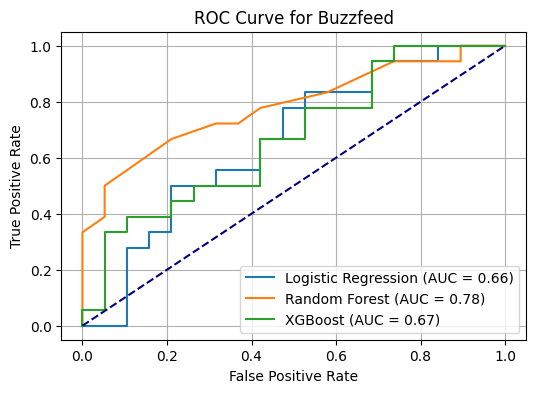


Plotting ROC Curve for FNC...


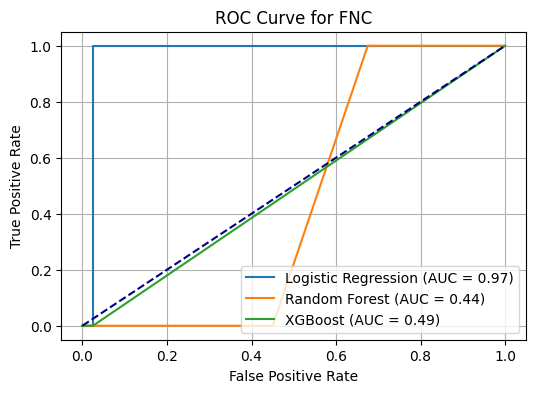


Plotting ROC Curve for LIAR...


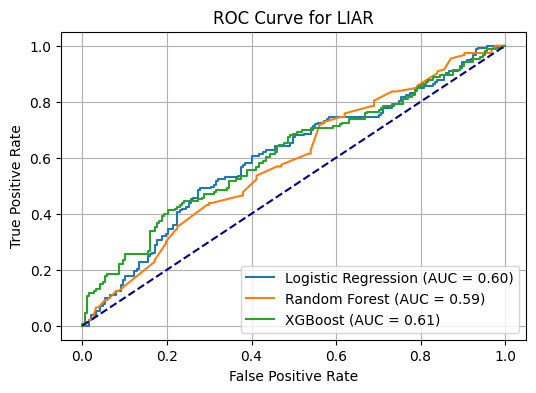


Plotting ROC Curve for Politifact...


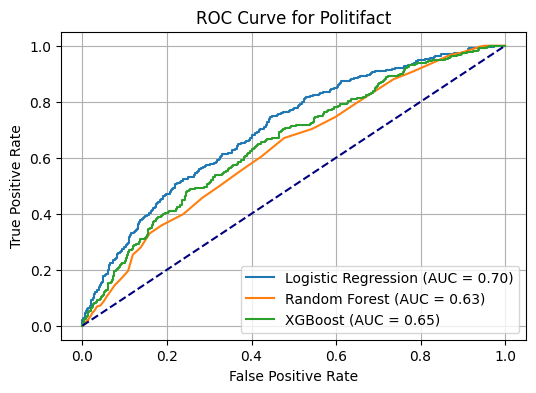

In [ ]:
# Plotting ROC Curves for Individual Datasets
# Evaluating the classification performance of models on each dataset using ROC curves and AUC scores.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary to store models and test data for ROC plotting
dataset_models = {}

def process_dataset(name, path):
    """Process a single dataset for preprocessing, modeling, and storing results for ROC curve plotting."""
    try:
        print(f"\nProcessing Dataset: {name}")
        df = pd.read_csv(path)
        df = preprocess_dataset(df, name)
        print(f"Shape After Preprocessing: {df.shape}")

        # TF-IDF vectorization
        print("Applying TF-IDF...")
        tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

        # Dimensionality reduction
        print("Reducing Dimensionality...")
        svd = TruncatedSVD(n_components=500, random_state=42)
        reduced_features = svd.fit_transform(tfidf_matrix)

        # Combine features
        labels = df['label'].values

        # Train-test split
        print(f"Splitting Data for {name}...")
        X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, stratify=labels, random_state=42)

        # Handle class imbalance
        try:
            print(f"Applying ADASYN for {name}...")
            adasyn = ADASYN(random_state=42)
            X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
        except Exception as e:
            print(f"Error applying ADASYN: {e}")
            print("Falling back to RandomOverSampler...")
            ros = RandomOverSampler(random_state=42)
            X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_balanced)
        X_test_scaled = scaler.transform(X_test)

        # Train models and store them in the dictionary
        models = {}

        # Logistic Regression
        print("Training Logistic Regression...")
        logreg = LogisticRegression(max_iter=1000, random_state=42)
        logreg.fit(X_train_scaled, y_train_balanced)
        models["Logistic Regression"] = logreg

        # Random Forest
        print("Training Random Forest...")
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train_balanced)
        models["Random Forest"] = rf

        # XGBoost
        print("Training XGBoost...")
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb.fit(X_train_scaled, y_train_balanced)
        models["XGBoost"] = xgb

        # Store models and test data in dataset_models
        dataset_models[name] = {
            "models": models,
            "X_test": X_test_scaled,
            "y_test": y_test
        }

    except Exception as e:
        print(f"Error processing dataset {name}: {e}")

# Process each dataset and store models
for name, path in datasets.items():
    process_dataset(name, path)

# Function to plot ROC curves
def plot_roc_curve_for_dataset(name, models, X_test, y_test):
    """
    Plot ROC curves for all models trained on a specific dataset.
    """
    plt.figure(figsize=(6, 4))
    for model_name, model in models.items():
        # Check if the model has `predict_proba` or `decision_function`
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]  # Probability for positive class
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            print(f"{model_name} does not support ROC plotting.")
            continue

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Random guess line
    plt.title(f"ROC Curve for {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC curves for each dataset
for dataset_name, data in dataset_models.items():
    print(f"\nPlotting ROC Curve for {dataset_name}...")
    plot_roc_curve_for_dataset(
        dataset_name,
        models=data["models"],
        X_test=data["X_test"],
        y_test=data["y_test"]
    )



### **Feature Engineering Model Design and Evaluation for combined Final Dataset**

In [ ]:
# Feature Engineering: Text Cleaning, TF-IDF, Sentiment Analysis, and Metadata Extraction

import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load Dataset
print("Loading Dataset...")
fake_news_dataset = pd.read_csv('/content/Fake_News_Dataset.csv')

# Step 1: Text Cleaning
print("Cleaning Text...")
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.lower()

fake_news_dataset['cleaned_text'] = fake_news_dataset['text'].apply(clean_text)

# Step 2: TF-IDF with Trigrams
print("Applying TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(fake_news_dataset['cleaned_text'])

# Dimensionality Reduction
print("Reducing Dimensionality...")
svd = TruncatedSVD(n_components=500, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Step 3: Sentiment Features
print("Adding Sentiment Features...")
analyzer = SentimentIntensityAnalyzer()
fake_news_dataset['vader_sentiment'] = fake_news_dataset['cleaned_text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

# Step 4: Temporal and Metadata Features
print("Extracting Metadata Features...")
# Date Parsing with Debugging
fake_news_dataset['date'] = pd.to_datetime(fake_news_dataset['date'], format='%Y-%m-%d', errors='coerce')
invalid_dates = fake_news_dataset[~fake_news_dataset['date'].notna()]
print(f"Found {len(invalid_dates)} invalid date entries.")

# Extract Temporal Features
fake_news_dataset['year'] = fake_news_dataset['date'].dt.year.fillna(-1).astype(int)
fake_news_dataset['month'] = fake_news_dataset['date'].dt.month.fillna(-1).astype(int)

# Extract Domain Safely
def extract_domain(url):
    try:
        return re.split(r'//|/', url)[1] if '//' in url else re.split(r'/', url)[0]
    except (IndexError, TypeError):
        return 'unknown'

fake_news_dataset['domain'] = fake_news_dataset['url'].apply(lambda x: extract_domain(x) if pd.notna(x) else 'unknown')

# Speaker Encoding
speaker_frequency = fake_news_dataset['speaker'].value_counts()
fake_news_dataset['speaker_encoded'] = fake_news_dataset['speaker'].map(speaker_frequency)

# Combine Features
print("Combining Features...")
metadata_features = fake_news_dataset[['vader_sentiment', 'year', 'month', 'speaker_encoded']].fillna(0).values
combined_features = np.hstack([tfidf_reduced, metadata_features])

# Labels
labels = fake_news_dataset['label'].factorize()[0]

# Save Features and Labels
print("Saving Processed Features...")
np.save('features.npy', combined_features)
np.save('labels.npy', labels)


Loading Dataset...
Cleaning Text...
Applying TF-IDF...
Reducing Dimensionality...
Adding Sentiment Features...
Extracting Metadata Features...
Found 34374 invalid date entries.
Combining Features...
Saving Processed Features...


Loading Features and Labels...
Removing Rare Class (Class 4)...
Splitting Data...
Applying SMOTE...
Scaling Features...
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.80      0.56      2371
           1       0.67      0.00      0.00       922
           2       0.57      0.51      0.54      2829
           3       0.00      0.00      0.00       750

    accuracy                           0.49      6872
   macro avg       0.42      0.33      0.28      6872
weighted avg       0.47      0.49      0.42      6872



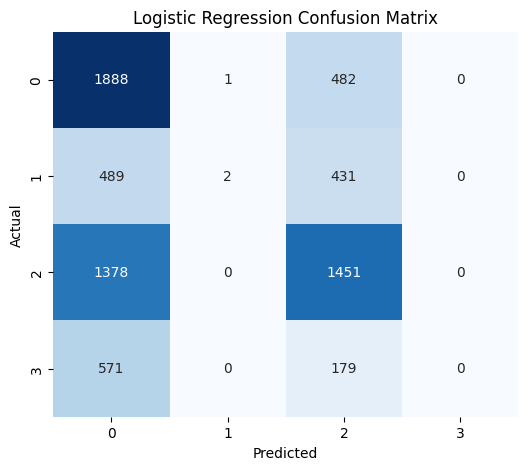

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.52      0.47      2371
           1       0.17      0.11      0.13       922
           2       0.57      0.54      0.56      2829
           3       0.33      0.33      0.33       750

    accuracy                           0.45      6872
   macro avg       0.38      0.37      0.37      6872
weighted avg       0.44      0.45      0.45      6872



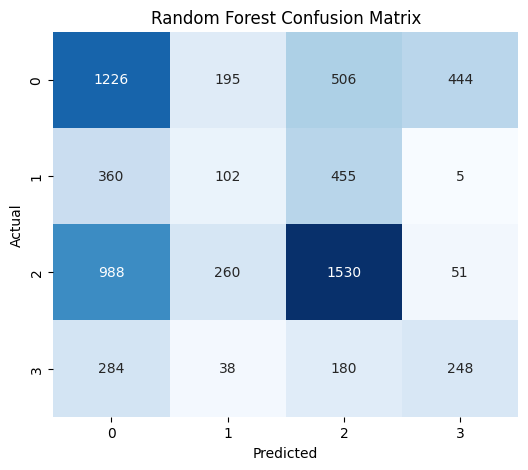

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}, Accuracy: 0.3789


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:16:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0}, Accuracy: 0.3910

Best XGBoost Accuracy: 0.3910

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.23      0.31      2371
           1       0.16      0.36      0.22       922
           2       0.57      0.54      0.56      2829
           3       0.29      0.37      0.32       750

    accuracy                           0.39      6872
   macro avg       0.37      0.38      0.35      6872
weighted avg       0.45      0.39      0.40      6872



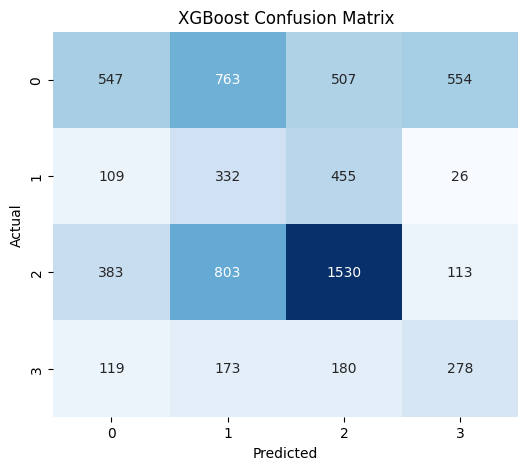

Evaluating Custom Ensemble Voting Classifier...

Custom Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.53      0.47      2371
           1       0.20      0.11      0.14       922
           2       0.57      0.51      0.54      2829
           3       0.33      0.34      0.34       750

    accuracy                           0.45      6872
   macro avg       0.38      0.37      0.37      6872
weighted avg       0.44      0.45      0.44      6872



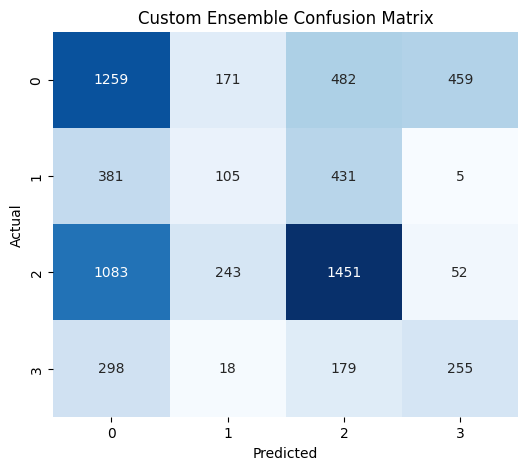


=== Model Accuracy Summary ===
Logistic Regression Accuracy: 0.4862
Random Forest Accuracy: 0.4520
Best XGBoost Accuracy: 0.3910
Custom Ensemble Voting Classifier Accuracy: 0.4467


In [ ]:
# Model Training and Evaluation with Ensemble Learning

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Step 1: Load Features and Labels
print("Loading Features and Labels...")
X = np.load('features.npy')
y = np.load('labels.npy')

# Step 2: Remove Rare Classes
print("Removing Rare Class (Class 4)...")
mask = y != 4
X, y = X[mask], y[mask]

# Step 3: Train-Test Split
print("Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Apply SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 5: Scaling Features
print("Scaling Features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Step 6: Logistic Regression
print("Training Logistic Regression...")
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train_balanced)
logreg_predictions = logreg.predict(X_test_scaled)
logreg_acc = accuracy_score(y_test, logreg_predictions)
print(f"\nLogistic Regression Classification Report:\n{classification_report(y_test, logreg_predictions)}")
logreg_cm = confusion_matrix(y_test, logreg_predictions)
plot_confusion_matrix(logreg_cm, classes=np.unique(y), title="Logistic Regression Confusion Matrix")

# Step 7: Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train_balanced)
rf_predictions = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_predictions)
print(f"\nRandom Forest Classification Report:\n{classification_report(y_test, rf_predictions)}")
rf_cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(rf_cm, classes=np.unique(y), title="Random Forest Confusion Matrix")

# Step 8: XGBoost
print("Training XGBoost...")
xgb_params = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 1.0}
]
best_xgb_acc = 0
best_xgb_model = None
for params in xgb_params:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, **params)
    xgb.fit(X_train_scaled, y_train_balanced)
    acc = accuracy_score(y_test, xgb.predict(X_test_scaled))
    print(f"Params: {params}, Accuracy: {acc:.4f}")
    if acc > best_xgb_acc:
        best_xgb_acc = acc
        best_xgb_model = xgb
print(f"\nBest XGBoost Accuracy: {best_xgb_acc:.4f}")
xgb_predictions = best_xgb_model.predict(X_test_scaled)
print(f"\nXGBoost Classification Report:\n{classification_report(y_test, xgb_predictions)}")
xgb_cm = confusion_matrix(y_test, xgb_predictions)
plot_confusion_matrix(xgb_cm, classes=np.unique(y), title="XGBoost Confusion Matrix")

# Step 9: Custom Voting Ensemble
print("Evaluating Custom Ensemble Voting Classifier...")
predictions = [
    logreg.predict_proba(X_test_scaled),
    rf.predict_proba(X_test_scaled),
    best_xgb_model.predict_proba(X_test_scaled)
]

# Weighted average of probabilities
weights = [1, 1, 2]  # Higher weight for XGBoost
ensemble_proba = np.average(predictions, axis=0, weights=weights)
ensemble_predictions = np.argmax(ensemble_proba, axis=1)

# Ensemble Accuracy
ensemble_acc = accuracy_score(y_test, ensemble_predictions)
print(f"\nCustom Ensemble Voting Classifier Classification Report:\n{classification_report(y_test, ensemble_predictions)}")
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
plot_confusion_matrix(ensemble_cm, classes=np.unique(y), title="Custom Ensemble Confusion Matrix")

# Step 10: Print Model Accuracy Summary
print("\n=== Model Accuracy Summary ===")
print(f"Logistic Regression Accuracy: {logreg_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Best XGBoost Accuracy: {best_xgb_acc:.4f}")
print(f"Custom Ensemble Voting Classifier Accuracy: {ensemble_acc:.4f}")


Loading Features and Labels...
Removing Rare Class (Class 4)...
Splitting Data...
Applying SMOTE...
Scaling Features...
Training Models...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Plotting ROC Curves...


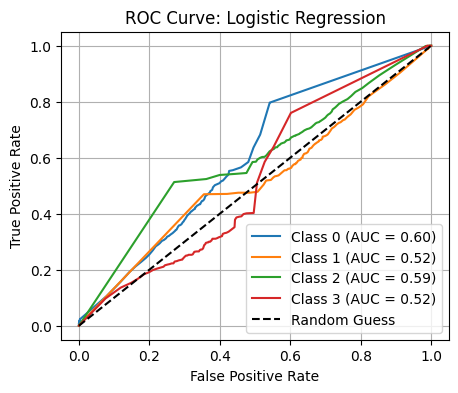

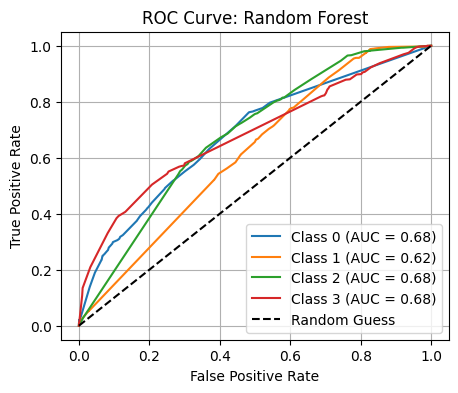

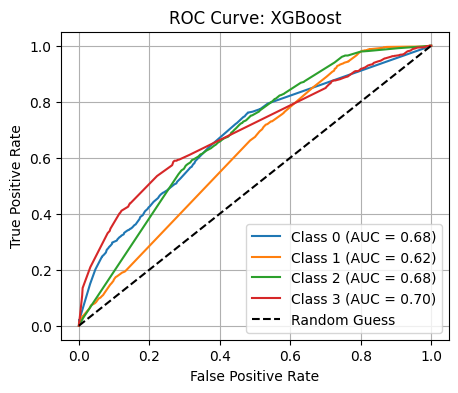

In [ ]:
# Plotting ROC Curves for all models
# Evaluating the multi-class classification performance of the models using ROC curves and AUC scores.


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve for a single model
def plot_model_roc_multiclass(model, X_test, y_test, n_classes, model_name):
    """
    Plots ROC curve for a single model across all classes.

    Parameters:
    - model: Trained model.
    - X_test (ndarray): Scaled test features.
    - y_test (ndarray): True labels for the test set.
    - n_classes (int): Number of unique classes.
    - model_name (str): Name of the model for the plot title.
    """
    # Binarize the labels for multi-class ROC
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

    plt.figure(figsize=(5, 4))
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        raise ValueError(f"{model_name} does not support probability predictions.")

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        auc_score = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Load Features and Labels
print("Loading Features and Labels...")
X = np.load('features.npy')
y = np.load('labels.npy')

# Remove Rare Classes
print("Removing Rare Class (Class 4)...")
mask = y != 4
X, y = X[mask], y[mask]
n_classes = len(np.unique(y))

# Train-Test Split
print("Splitting Data...")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale Features
print("Scaling Features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Train Models
print("Training Models...")

# Logistic Regression
from sklearn.linear_model import LogisticRegression
print("Training Logistic Regression...")
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train_balanced)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train_balanced)

# XGBoost
from xgboost import XGBClassifier
print("Training XGBoost...")
xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, subsample=1.0, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_scaled, y_train_balanced)

# Plot ROC Curves
print("Plotting ROC Curves...")
plot_model_roc_multiclass(logreg, X_test_scaled, y_test, n_classes, "Logistic Regression")
plot_model_roc_multiclass(rf, X_test_scaled, y_test, n_classes, "Random Forest")
plot_model_roc_multiclass(xgb, X_test_scaled, y_test, n_classes, "XGBoost")
